# Urbanity

# Data Acquisition

This notebook downloads the urbanity dataset from Figshare.

## Setup

First, we'll import the necessary libraries and set up the environment.


In [26]:
import os
import requests
from pathlib import Path
from tqdm.notebook import tqdm

selected_cities = ['Amsterdam', 'Athens', 'Barcelona', 'Berlin']

city_graph = {
    'Amsterdam': {
        'nodes': ["https://figshare.com/ndownloader/files/40160350"],
        'edges': ["https://figshare.com/ndownloader/files/40160347"]
    },
    'Athens': {
        'nodes': ["https://figshare.com/ndownloader/files/40160368"],
        'edges': ["https://figshare.com/ndownloader/files/40160365"]
    },
    'Barcelona': {
        'nodes': ["https://figshare.com/ndownloader/files/40160377"],
        'edges': ["https://figshare.com/ndownloader/files/40160374"]
    },
    'Berlin': {
        'nodes': ["https://figshare.com/ndownloader/files/40160389"],
        'edges': ["https://figshare.com/ndownloader/files/40160386"]
    }
}

def download_file(url, filename):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        total_size = int(response.headers.get('content-length', 0))
        block_size = 1024  # 1 KB
        with open(filename, 'wb') as f, tqdm(
            desc=filename.name,
            total=total_size,
            unit='iB',
            unit_scale=True,
            unit_divisor=1024,
        ) as progress_bar:
            for data in response.iter_content(block_size):
                size = f.write(data)
                progress_bar.update(size)
    else:
        print(f"Failed to download {filename}. Status code: {response.status_code}")

base_path = Path('../../data/0-raw/Urbanity')
base_path.mkdir(parents=True, exist_ok=True)

total_files = sum(len(data) for data in city_graph.values())
with tqdm(total=total_files, desc="Overall Progress") as overall_pbar:
    for city, data in city_graph.items():
        city_path = base_path / city
        city_path.mkdir(exist_ok=True)
        
        for data_type in ['nodes', 'edges']:
            url = data[data_type][0]
            filename = city_path / f"{city.lower()}_{data_type}.geojson"
            download_file(url, filename)
            overall_pbar.update(1)

print("All files have been downloaded.")

Overall Progress:   0%|          | 0/8 [00:00<?, ?it/s]

amsterdam_nodes.geojson:   0%|          | 0.00/28.4M [00:00<?, ?iB/s]

amsterdam_edges.geojson:   0%|          | 0.00/69.0M [00:00<?, ?iB/s]

athens_nodes.geojson:   0%|          | 0.00/78.4M [00:00<?, ?iB/s]

athens_edges.geojson:   0%|          | 0.00/212M [00:00<?, ?iB/s]

barcelona_nodes.geojson:   0%|          | 0.00/18.0M [00:00<?, ?iB/s]

barcelona_edges.geojson:   0%|          | 0.00/48.1M [00:00<?, ?iB/s]

berlin_nodes.geojson:   0%|          | 0.00/174M [00:00<?, ?iB/s]

berlin_edges.geojson:   0%|          | 0.00/369M [00:00<?, ?iB/s]

All files have been downloaded.


/var/folders/ws/t5rn8lfd1m71dktv64gnqgjc0000gn/T/ipykernel_54316/3771688200.py:37: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  city_centers = pd.read_csv('../../data/0-raw/Global-StreetScapes/data/simplemaps.csv')


City: Amsterdam
Number of edges before clipping: 62432
Number of edges after clipping: 5182
Bounding box: (541206.4693907929, 6864303.04131815, 546006.4693907929, 6869103.04131815)
Sample edge coordinates: (546419.2234924628, 6866051.127168273)
---
City: Athens
Number of edges before clipping: 195810
Number of edges after clipping: 12204
Bounding box: (2639000.009491875, 4574794.043157505, 2643800.009491875, 4579594.043157505)
Sample edge coordinates: (2638615.085262903, 4567660.616362805)
---
City: Barcelona
Number of edges before clipping: 42604
Number of edges after clipping: 5540
Bounding box: (239931.39950787724, 5066525.0908079455, 244731.39950787724, 5071325.0908079455)
Sample edge coordinates: (243521.7499548788, 5067124.81631219)
---
City: Berlin
Number of edges before clipping: 336900
Number of edges after clipping: 5258
Bounding box: (1487422.1411336183, 6891696.1038206285, 1492222.1411336183, 6896496.1038206285)
Sample edge coordinates: (1514528.6894829024, 6867932.12322386

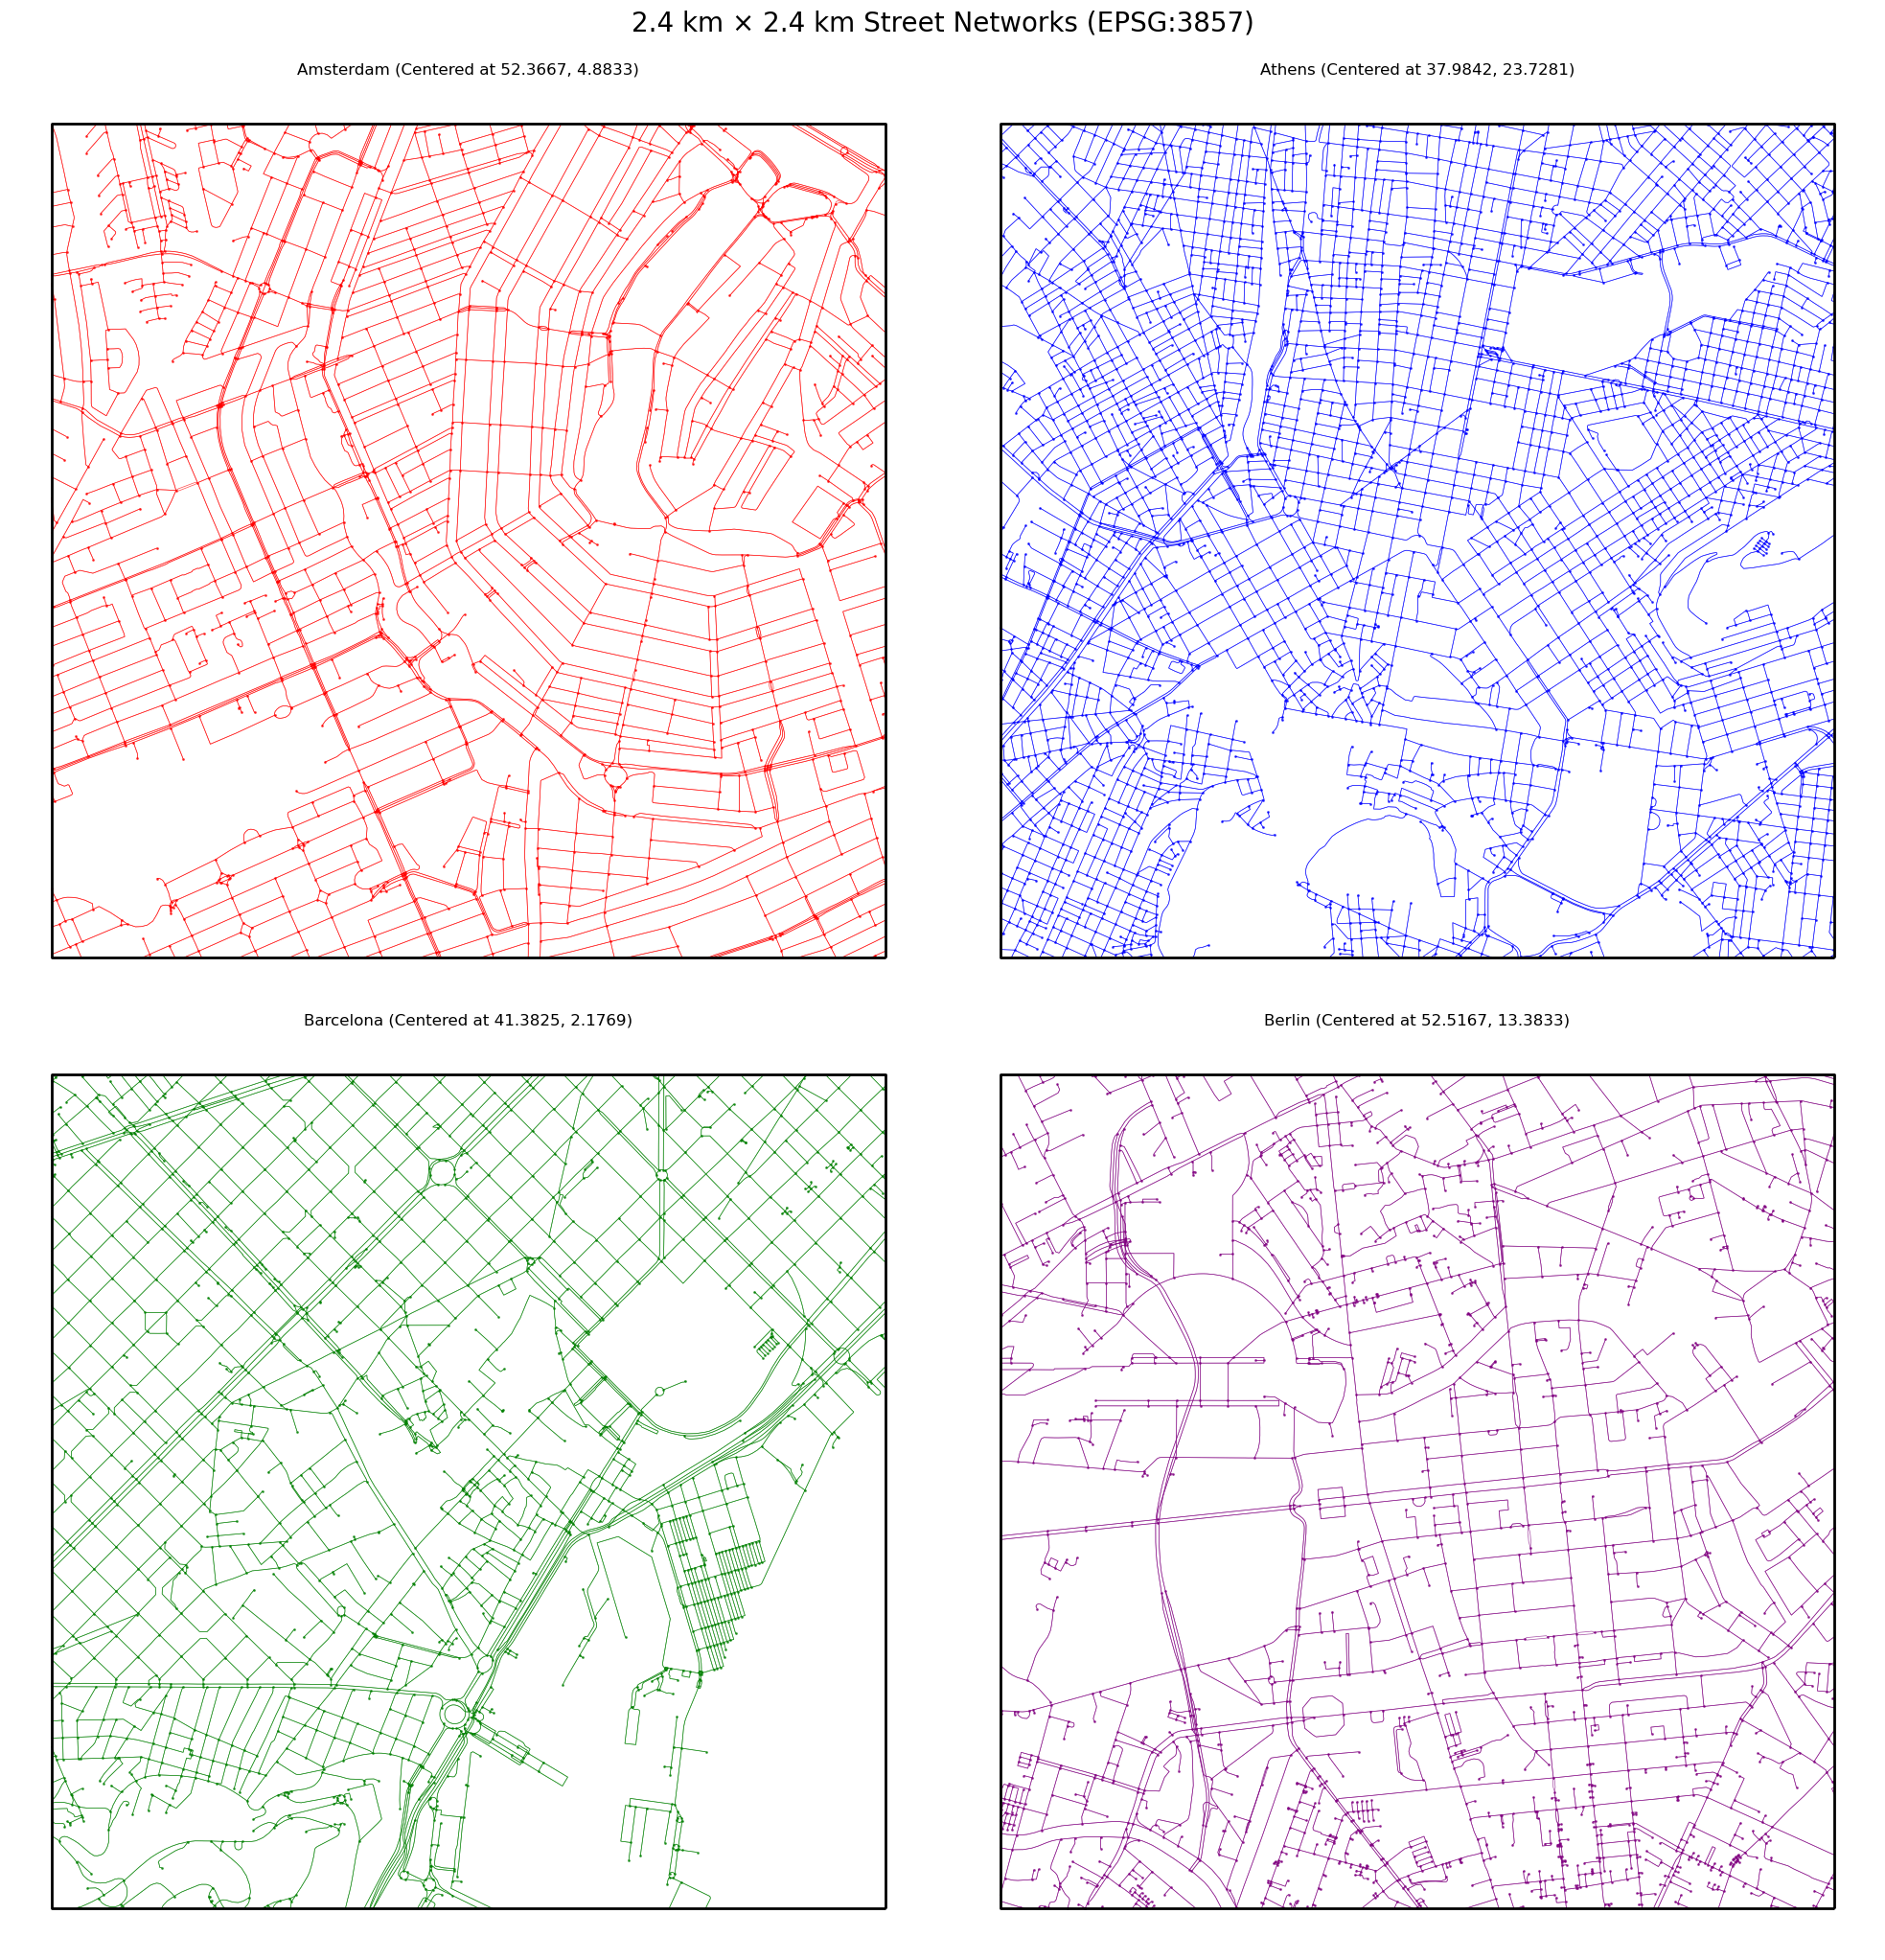

In [28]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box, Point
import pandas as pd
import numpy as np
from pyproj import CRS
from pathlib import Path

# Define your base path
base_path = Path('../../data/0-raw/Urbanity')

# Function to load city data
def load_city_data(city_name):
    city_path = base_path / city_name
    nodes = gpd.read_file(city_path / f"{city_name.lower()}_nodes.geojson")
    edges = gpd.read_file(city_path / f"{city_name.lower()}_edges.geojson")
    return nodes, edges

# Function to create a 2.4 km x 2.4 km bounding box in EPSG:3857
def create_bbox(lat, lon, size_m=2400):
    # Create a GeoDataFrame with the center point
    center_point = gpd.GeoDataFrame(geometry=[Point(lon, lat)], crs='EPSG:4326')
    # Project to EPSG:3857
    center_point_proj = center_point.to_crs(epsg=3857)
    x_center = center_point_proj.geometry.x.iloc[0]
    y_center = center_point_proj.geometry.y.iloc[0]
    # Create a square box around the center point in meters
    bbox_proj = box(
        x_center - size_m,
        y_center - size_m,
        x_center + size_m,
        y_center + size_m
    )
    return bbox_proj

# Load city centers from CSV
city_centers = pd.read_csv('../../data/0-raw/Global-StreetScapes/data/simplemaps.csv')
city_centers = city_centers[city_centers['city'].isin(['Amsterdam', 'Athens', 'Barcelona', 'Berlin'])]

# Ensure 'city' is unique to prevent Series conversion errors
city_centers = city_centers.drop_duplicates(subset=['city'])

# Set 'city' as the index for easier access
city_centers = city_centers.set_index('city')

# Create a figure with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 20))
axs = axs.flatten()

# Define colors for each city
city_colors = {
    'Amsterdam': 'red',
    'Athens': 'blue',
    'Barcelona': 'green',
    'Berlin': 'purple'
}

# Plot all four cities
for idx, city in enumerate(['Amsterdam', 'Athens', 'Barcelona', 'Berlin']):
    nodes, edges = load_city_data(city)
    
    # Ensure CRS is set to EPSG:4326
    nodes = nodes.set_crs(epsg=4326, allow_override=True)
    edges = edges.set_crs(epsg=4326, allow_override=True)
    
    # Get the center coordinates from the CSV
    center_lat = float(city_centers.at[city, 'city_lat'])
    center_lon = float(city_centers.at[city, 'city_lon'])
    
    # Create the bounding box in EPSG:3857
    bbox_proj = create_bbox(center_lat, center_lon)
    
    # Project nodes and edges to EPSG:3857
    nodes_proj = nodes.to_crs(epsg=3857)
    edges_proj = edges.to_crs(epsg=3857)
    
    # Create a GeoDataFrame for the bounding box
    bbox_gdf = gpd.GeoDataFrame({'geometry': [bbox_proj]}, crs='EPSG:3857')

    # Clip nodes and edges to the bbox
    nodes_clipped = gpd.clip(nodes_proj, bbox_gdf)
    edges_clipped = gpd.clip(edges_proj, bbox_gdf)

    # Plot the clipped edges and nodes
    ax = axs[idx]
    edges_clipped.plot(ax=ax, color=city_colors[city], linewidth=0.5, alpha=0.7)
    nodes_clipped.plot(ax=ax, color=city_colors[city], markersize=1, alpha=0.7)
    
    # Plot the bounding box
    bbox_gdf.boundary.plot(ax=ax, color='black', linewidth=2)
    
    # Set the aspect of the plot to equal for accurate geography
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(f"{city} (Centered at {center_lat:.4f}, {center_lon:.4f})")

    # Debug information
    print(f"City: {city}")
    print(f"Number of edges before clipping: {len(edges_proj)}")
    print(f"Number of edges after clipping: {len(edges_clipped)}")
    print(f"Bounding box: {bbox_proj.bounds}")
    print(f"Sample edge coordinates: {edges_proj.iloc[0].geometry.coords[0] if len(edges_proj) > 0 else 'No edges'}")
    print("---")

# Adjust layout and add main title
plt.tight_layout()
fig.suptitle("2.4 km Ã— 2.4 km Street Networks (EPSG:3857)", fontsize=20, y=1.02)

# Display the plot
plt.show()
